# Machine Vision<br>Assignment 2 - Color spaces

## Personal details

* **Name(s):** `XX`
* **Student ID(s):** `XX`

## 1. Introduction

This assignment explores the RGB and HSV color spaces. We will implement a skin detector based on simple color comparisons. The detector should mark the pixels that are the same color as a reference skin patch. Perform the following operations in the reserved code cells and answer the questions.
<img src="attachment:result.jpg" width="700">

## 2. Color spaces

The RGB and HSV color spaces are both very common in computer vision. They serve different purposes. RGB is a linear space and directly represents the colors as recorded by most cameras and as displayed by most screens. HSV on the other hand is a non-linear space and it correlates better to how we humans perceive colors. In other words, compared to RGB, the distances calculated between two colors in HSV space more closely resemble the distance that a human would assign them. Figure 2 shows a plot of RGB and HSV color cubes. The RGB and HSV colors can be represented as vectors with three components, each component ranging from 0 to 1. 
<img src="attachment:cubes.jpg" width="600">

Let us first read the image `face.jpg` and extract a rectangular region with skin-color. We make sure that values are in range $[0,1]$.

(-0.5, 79.5, 19.5, -0.5)

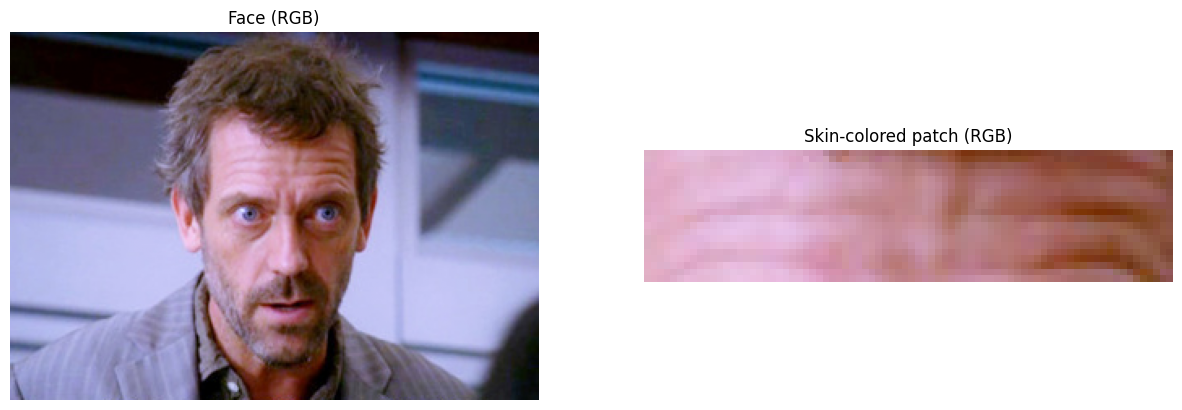

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Read the image and convert to RGB and HSV
img = cv2.imread('face.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Normalize components to range [0,1]
img_rgb = img_rgb/255
h, s, v = cv2.split(img_hsv)
img_hsv = np.dstack((h/180,s/255,v/255))

# Extract a patch with skin-color
patch_rgb = img_rgb[70:90,130:210,:]
patch_hsv = img_hsv[70:90,130:210,:]

# Display
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(img_rgb)
plt.title('Face (RGB)')
plt.axis('off')
plt.subplot(122)
plt.imshow(patch_rgb)
plt.title('Skin-colored patch (RGB)')
plt.axis('off')

**2.1. Compute mean color** $\quad$ <font color=red>(0.50 points)</font>

Our skin detector will be very simple. It will be trained to learn the mean color of the skin and what is the maximum distance that a pixel can be from this to be classified as skin. Complete the function `computeMeanColor()` in the following code cell. The function should return the mean color of a given image patch.

In [2]:
# INPUT   
# colors : RGB or HSV colors (NxMx3 matrix)
#
# OUTPUT  
# mean_color : Mean color (3x1 vector)
#
def computeMeanColor(colors):
    
    # The following line can be removed
    # mean_color = np.zeros(3)
    
    # ---------- YOUR CODE STARTS HERE -----------
    mean_color = np.mean(colors, axis=(0, 1))
    
    
    
    # ----------- YOUR CODE ENDS HERE ------------
    
    return mean_color

mean_rgb = computeMeanColor(patch_rgb)
mean_hsv = computeMeanColor(patch_hsv)

In [3]:
# LEAVE EMPTY

**2.2. Visualize the colors of the skin-patch**

Let us visualize the color content of the skin-patch in both color spaces (RGB and HSV). We will use scatter plots similar to the sample code __[`Color.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Color.ipynb)__. We will also plot the mean colors `mean_rgb` and `mean_hsv`. If your function `computeMeanColor()` is correct, the mean values should be similar to the ones in Figure 3.

Text(0.5, 0.92, 'Skin colors in HSV space')

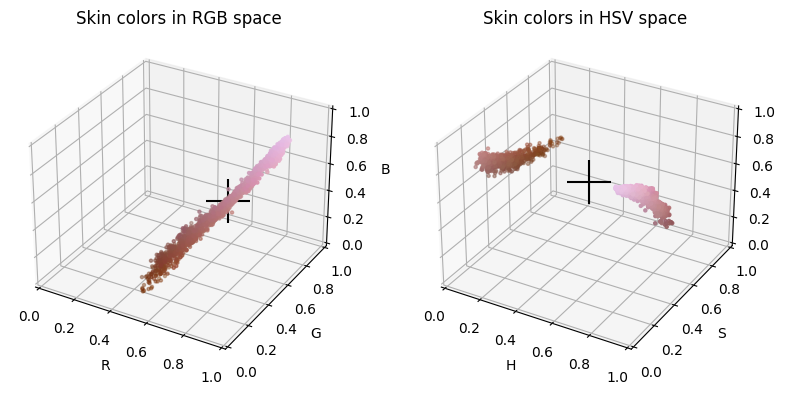

In [4]:
# Figure is twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# Visualize RGB
r, g, b = cv2.split(patch_rgb)
r, g, b = (r.ravel(), g.ravel(), b.ravel())
color = np.array((r, g, b),dtype=np.float32).T
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(r, g, b, c=color, marker=".")
ax.scatter(mean_rgb[0],mean_rgb[1],mean_rgb[2], s=1000, facecolor="black", marker="+")
ax.set_xlabel("R")
ax.set_ylabel("G")
ax.set_zlabel("B")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)
ax.set_title("Skin colors in RGB space")

# Visualize HSV
h, s, v = cv2.split(patch_hsv)
h, s, v = (h.ravel(), s.ravel(), v.ravel())
ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.scatter(h, s, v, c=color, marker=".")
ax.scatter(mean_hsv[0],mean_hsv[1],mean_hsv[2], s=1000, facecolor="black", marker="+")
ax.set_xlabel("H")
ax.set_ylabel("S")
ax.set_zlabel("V")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)
ax.set_title("Skin colors in HSV space")


**2.3. Answer the questions** $\quad$ <font color=red>(0.50 points)</font>

**Q1:**  Observe the HSV cube in Figure 2. How does the hue affect the color when saturation is zero?

`Change in hue does not affect the color when the saturation is zero.`

**Q2:** Observe the plotted skin colors. Why are the colors in HSV space split into two different groups?

`HSV is non-linear. The darker tones' values are drastically different to the lighter tones, if the colors were presented is a linear manner, there would be unwanted colors in the figure.`

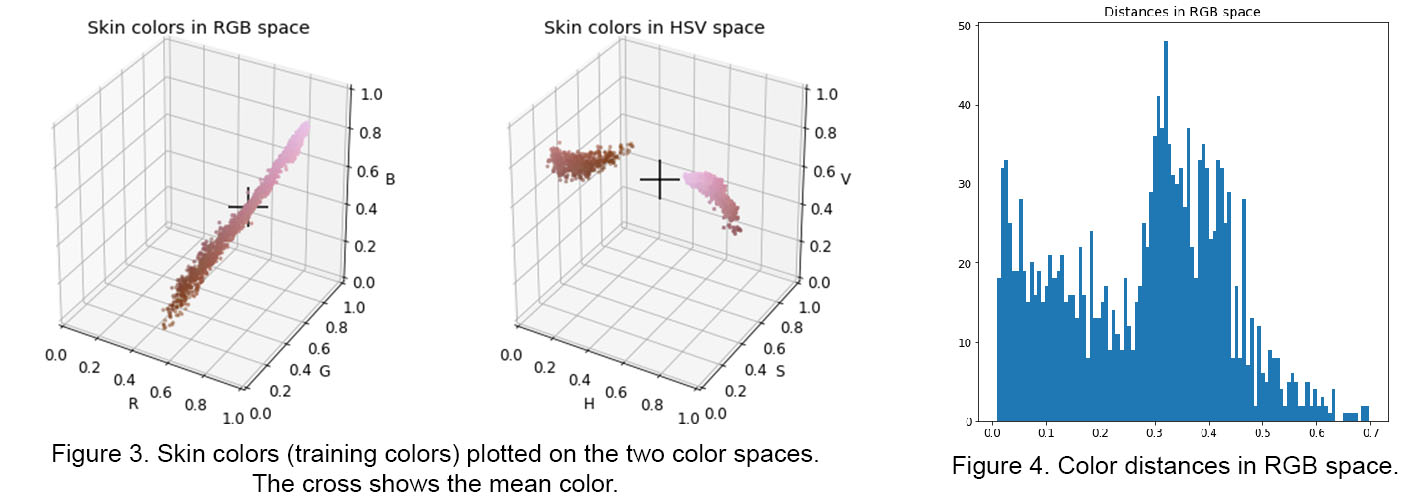

## 3. Skin detection (RGB space)

To detect skin pixels, we need to compute distances between the colors. For each pixel, we will compute the distance between the learned mean color and the pixel's color. If the distance is below a threshold, the pixel is classified as skin. 

Let us first implement our skin detector in RGB color space. Since RGB is a linear space, the distance between two colors is trivially obtained by the L2-norm:

$$
d_{rgb} = |\mathbf{c}_a - \mathbf{c}_b| = \sqrt{(r_a-r_b)^2 + (g_a-g_b)^2 + (b_a-b_b)^2} \qquad (1)
$$

**3.1. Calculate color distances** $\quad$ <font color=red>(0.50 points)</font>

Complete the following code cell. The function `computeDistances()` should compute the distances between a set of colors and the mean color (ref). Use the above formula to compute the distances. Once you have completed the function, run the code cell. You should obtain a plot similar to Figure 4.

Text(0.5, 1.0, 'Distances in RGB space')

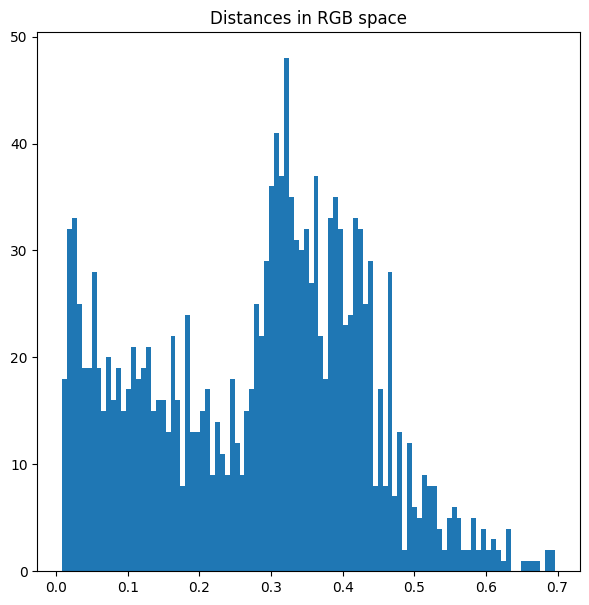

In [5]:
# INPUTS
# colors : RGB or HSV colors (NxMx3 matrix)
# ref    : Reference color (3x1 vector)
#
# OUTPUT
# dists  : Distances (L2-norm) between the reference color 
#          'ref' and each entry of 'colors' (NxM matrix)
#
def computeDistances(colors,ref):
      
    # ---------- YOUR CODE STARTS HERE -----------
    dists = np.empty((len(colors), len(colors[0])))

    for ix, x in enumerate(colors):
        temp = []

        for iy, y in enumerate(x):
            xd = np.sqrt((ref[0] - colors[ix][iy][0])**2 + (ref[1] - colors[ix][iy][1])**2 + (ref[2] - colors[ix][iy][2])**2)
            temp.append(xd)

        dists[ix] = temp
    
    
    # ----------- YOUR CODE ENDS HERE ------------
    
    return dists

dists_rgb = computeDistances(patch_rgb,mean_rgb)

# Show histogram of the distances of the 
# training colors to the mean
plt.figure(figsize=(7,7))
plt.hist(dists_rgb.flatten(),100)
plt.title('Distances in RGB space')


In [6]:
# LEAVE EMPTY

Notice that even though all the pixels in the selected region are skin pixels, the actual colors can be very different. The pixels in RGB space cover a large volume and are hard to model by a single representative color (Figure 3). Nevertheless, let us continue implementing the skin detector.

**3.2. Thresholding**

We are now ready to calculate a threshold distance for skin detection. The provided function `findThreshold()` selects a threshold that classifies 95% of the training data as skin. Using 95% instead of 100% gives some resistance to outliers. Execute the following code cell to detect the skin pixels. Notice how many of the pixels are misclassified when using RGB color space.


Threshold (RGB): 0.5136


(-0.5, 325.5, 226.5, -0.5)

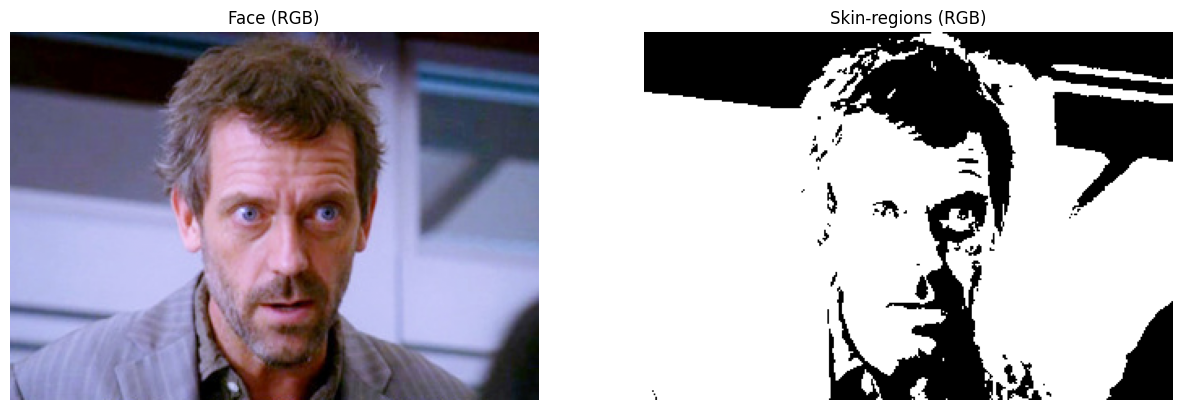

In [7]:
# Finds a suitable threshold to segment an image given a set 
# of training points that belong to the region.
def findThreshold(dists):
    
    # Sort distances to ascending order
    dists = np.sort(dists.ravel())

    N = dists.size
    inliers = 0.95 # Inlier percentage
    idx = np.around(inliers*N).astype(int)
    threshold = dists[idx]
    
    return threshold

threshold = findThreshold(dists_rgb)
print('Threshold (RGB): %.4f' % threshold)

dists = computeDistances(img_rgb,mean_rgb)
seg = (dists < threshold)

# Display
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(img_rgb)
plt.title('Face (RGB)')
plt.axis('off')
plt.subplot(122)
plt.imshow(seg,cmap='gray')
plt.title('Skin-regions (RGB)')
plt.axis('off')

## 4. Skin detection (HSV space)

In this section, we implement the same skin detector using HSV color space. Again, we need to compute distances between the colors. However, the HSV space is non-linear. Recall that skin colors were split into two different groups (Figure 3). The formula (1) would give an incorrect distance if applied directly to the HSV color values. Instead of a cube, a better representation for the HSV space is a cone, as in Figure 5. If we translate HSV units to a point inside the cone, this transformed space is linear and we can apply normal operators to the transformed color values (e.g. L2-norm, mean).
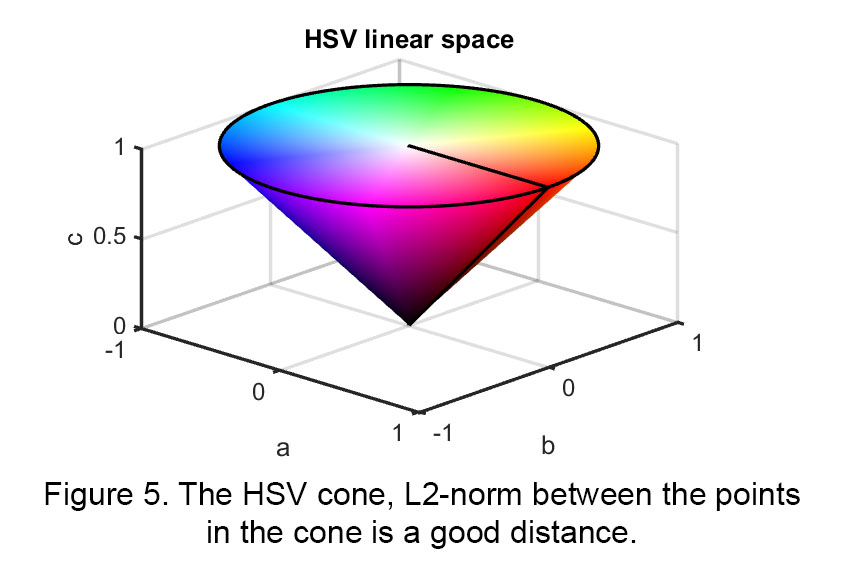

In the linear space, the hue indicates the angle around the vertical axis, the saturation indicates the distance from the axis, and the value the distance along the axis. The equations to transform the HSV coordinates $(h,s,v)$ to the linear space $(a,b,c)$ are:

$$
a = sv\,\text{cos}(2 \pi h), \quad b = sv\,\text{sin}(2 \pi h), \quad c = v \qquad (2)
$$

Once the color has been transformed to this linear space, the L2-norm gives a good distance between points. Conversely, the equations to transform the point back to HSV space are:

$$
h = \frac{ \text{atan2}(b,a) }{ 2\pi}, \quad s = \frac{ \sqrt{a^2 + b^2} }{c}, \quad v = c, \qquad (3)
$$

although these equations are not needed in this assignment.

**4.1. Transform HSV colors to linear space** $\quad$ <font color=red>(0.50 points)</font>

Complete the following code cell. Use the formula (2) to convert HSV colors to linear space. Note that input and output dimensions should be equal (NxMx3).

In [8]:
# INPUTS
# colors_hsv : Colors in HSV space (NxMx3 matrix)
#
# OUTPUT
# colors_lin : Colors in linear HSV space (NxMx3 matrix)
#
def hsvToLinear(colors_hsv):
    
    # ---------- YOUR CODE STARTS HERE -----------
    colors_lin = np.empty((len(colors_hsv), len(colors_hsv[0]), len(colors_hsv[0][0])))
    
    for ix, x in enumerate(colors_hsv):
        
        for iy, y in enumerate(x):
            a = colors_hsv[ix][iy][1] * colors_hsv[ix][iy][2] * np.cos(2 * np.pi * colors_hsv[ix][iy][0])
            b = colors_hsv[ix][iy][1] * colors_hsv[ix][iy][2] * np.sin(2 * np.pi * colors_hsv[ix][iy][0])
            c = colors_hsv[ix][iy][2]

            colors_lin[ix][iy] = [a, b, c]

            # colors_lin[ix][iy] = y[1] * y[2] * np.cos(2 * np.pi * y[0])
            # colors_lin[ix][iy] = y[1] * y[2] * np.sin(2 * np.pi * y[0])
            # colors_lin[ix][iy] = y[2]

    return colors_lin

    # dists = np.empty((len(colors), len(colors[0])))

    # for ix, x in enumerate(colors):
    #     temp = []

    #     for iy, y in enumerate(x):
    #         xd = np.sqrt((ref[0] - colors[ix][iy][0])**2 + (ref[1] - colors[ix][iy][1])**2 + (ref[2] - colors[ix][iy][2])**2)
    #         temp.append(xd)

    #     dists[ix] = temp
    
    # ----------- YOUR CODE ENDS HERE ------------
    
    return colors_lin


In [9]:
# LEAVE EMPTY

**4.2. Testing**

Execute the following code cell to detect the skin pixels. If you have implemented `hsvToLinear()` correctly, the result should be similar to Figure 1. Notice also that the distances in the HSV space are smaller, meaning that the model fits better to the training data.

Threshold (HSV): 0.2884


(-0.5, 325.5, 226.5, -0.5)

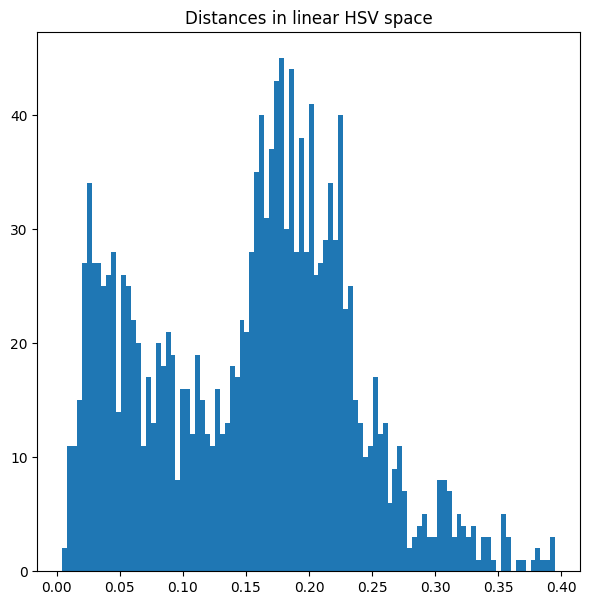

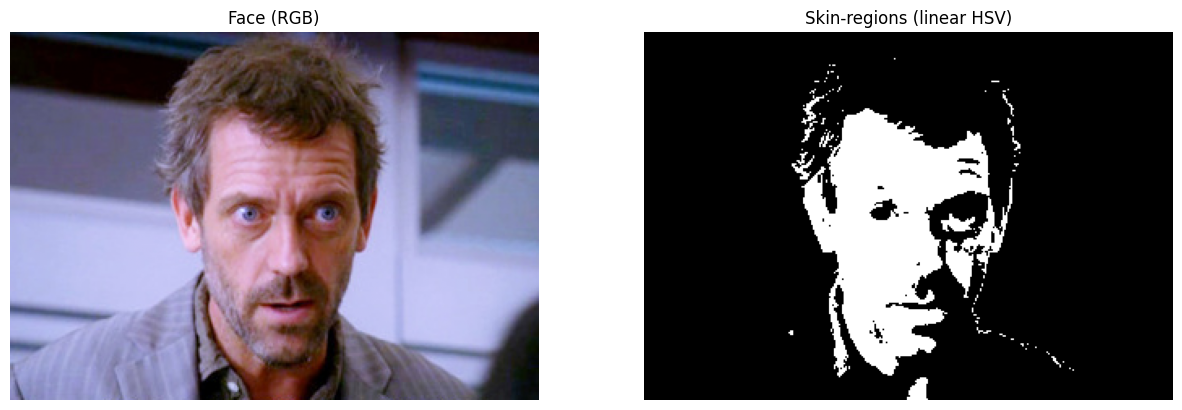

In [10]:
patch_lin = hsvToLinear(patch_hsv)

# Find the threshold
mean_lin = computeMeanColor(patch_lin)
dists = computeDistances(patch_lin,mean_lin)
threshold = findThreshold(dists)
print('Threshold (HSV): %.4f' % threshold)

# Show histogram of distances
plt.figure(figsize=(7,7))
plt.hist(dists.flatten(),100)
plt.title('Distances in linear HSV space')

# Threshold
img_lin = hsvToLinear(img_hsv)
dists = computeDistances(img_lin,mean_lin)
seg = (dists < threshold).astype(int)

# Display
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(img_rgb)
plt.title('Face (RGB)')
plt.axis('off')
plt.subplot(122)
plt.imshow(seg,cmap='gray')
plt.title('Skin-regions (linear HSV)')
plt.axis('off')

# Aftermath
Finally, fill your answers to the following questions:

**How much time did you need to complete this exercise?**

`4 hours.`

**Did you experience any problems with the exercise? Was there enough help available? Should this notebook be more (or less) detailed?**

`The handling of numpy arrays took most of the time as I did not understand how to work with them.`

# References
`LIST YOUR POSSIBLE REFERENCES HERE!`

# Submission

1. Click on the menu `Kernel -> Restart & Clear Output` to clear all outputs and variables, etc.
2. Compress the resulting Jupyter notebook (`MV_A2.ipynb` file) into **`MV_A2_[student number(s)].zip`** (e.g. `MV_A2_1234567.zip` if solo work or `MV_A2_1234567-7654321.zip` if pair work). Please only include .ipynb file (no other files or folders).
3. Upload the .zip file to Moodle. The return box can be found in the assignments section.

**Deadline of the assignment 26.1.2023**